# Homework 9 - Parameter Search and Feature Selection
In this assignment, you will be working with the cars dataset to perform parameter search and feature selection using various techniques. The goal is to explore the performance of a machine learning model by optimizing its parameters and selecting the most relevant features. We will try to predict the Make of the car based on its attributes.

Complete the missing parts in this guide.

### Step 1: Load Data
You can load the data from the provided CSV file using `pandas`.

### Step 2: Preprocess and split data
Use attributes `['Make', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'MSRP']` (x) to predict the `Make` (y, target variable). Note that `Make` is a categorical variable, so you will need to use a classification model.
 - You should handle missing values appropriately (suggestion: drop rows with missing values).
 - You should remove Makes that have less than 20 samples.
 - You should split the data into training and testing sets.

### Step 3: Predict Make using a Decision Tree Classifier
Use a Decision Tree Classifier to predict the `Make` of the car. You will need to:
 - Train the model on the training set.
 - Evaluate the model on the test set using different metrics (use the `report` function from `sklearn.metrics`).
 - Showcase the confusion matrix to visualize the performance of the model. Do you see any interesting patterns in the confusion matrix?

### Step 4: Perform Parameter Search
Use `GridSearchCV` to perform a parameter search on the Decision Tree Classifier. You can use `criterion`, `max_depth`, and `splitter` as parameters to search over. Check the documentation for Decistion Tree Classifier to see the available parameters.
 - Discuss if the model performance improved after the parameter search.

### Step 5: Feature Selection
Use the best model from the parameter search to perform feature selection. Use `feature_importances_` to get the importance of each feature in the model. You can use `SelectFromModel` from `sklearn.feature_selection` to select the most important features based on the model's feature importances.
 - You can visualize the feature importances using a bar chart for better understanding.
 - Discuss which features are most important and how they impact the model's performance.
 
### Step 6: Plot ROC Curve and calculate AUC
Use the best model from the parameter search to plot the ROC curve and calculate the AUC (Area Under the Curve) score for one of the classes (e.g., `Toyota`). You can use `roc_curve` and `auc` from `sklearn.metrics` to do this. You can use the method `predict_proba` to get the probabilities for each class.

### Step 7: Repeat 3-6 for Logistic Regression, KNeighborsClassifier, RandomForestClassifier, and SVM(SVC).
 - Compare the performance of the classifiers using the same metrics as before.
 - Discuss which classifier performed best and why.
 - Check the documentation or ask for help if you are unsure about the parameters to use for each classifier. For instance, for KNeighborsClassifier, you can search over `n_neighbors` and `weights`.


## Dataset Overview
The cars dataset contains several attributes of various car models, including their specifications and performance metrics.

## Submission Guidelines

- Submit your completed notebook as a HTML export, or a PDF file.

To export to HTML, if you are on Jupyter, select `File` > `Export Notebook As` > `HTML`.

If you are on VSCode, you can use the `Jupyter: Export to HTML` command.
 - Open the command palette (Ctrl+Shift+P or Cmd+Shift+P on Mac).
     - Search for `Jupyter: Export to HTML`.
     - Save the HTML file to your computer and submit it via Canvas.

Make sure the plots appear in the exported file. If you are using plotly or more complicated interactive plots, make sure to a bitmap backend like 'png'.


Let's start by loading several libraries that we will need for this assignment.


In [1]:
import pandas as pd
import sqlite3

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np      # Added

Now we need to import the data. This time we will import the `carfeatures.csv` from the Datasets folder. Make any adjustments to the path as necessary.


In [2]:
df = pd.read_csv("../Datasets/carfeatures.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

We will use only a subset of the columns for this assignment. Let's select them:
We want to predict `Make`.

In [4]:
# Our variables
x_features = [
'Engine HP',
'Engine Cylinders',
'Number of Doors',
'highway MPG',
'city mpg',
'MSRP'
]

# Target variable
y_feature = 'Make'


Next, we need to drop rows with missing values among the selected columns. (You can use `dropna()` method from pandas with a `subset` parameter that restricts the operation to the selected columns.)

In [5]:
# remove rows with missing values in x_features

# Combine the feature columns and the target column
columns_to_check = x_features + [y_feature]

df = df.dropna(subset=columns_to_check) # COMPLETE

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11815 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11815 non-null  object 
 1   Model              11815 non-null  object 
 2   Year               11815 non-null  int64  
 3   Engine Fuel Type   11812 non-null  object 
 4   Engine HP          11815 non-null  float64
 5   Engine Cylinders   11815 non-null  float64
 6   Transmission Type  11815 non-null  object 
 7   Driven_Wheels      11815 non-null  object 
 8   Number of Doors    11815 non-null  float64
 9   Market Category    8084 non-null   object 
 10  Vehicle Size       11815 non-null  object 
 11  Vehicle Style      11815 non-null  object 
 12  highway MPG        11815 non-null  int64  
 13  city mpg           11815 non-null  int64  
 14  Popularity         11815 non-null  int64  
 15  MSRP               11815 non-null  int64  
dtypes: float64(3), int64(5), ob

We need to remove rows where the `Make` has not many samples. We can use `value_counts()` to find the counts of each Make. I recommend to plot value counts to visualize the distribution of Makes. Let's see how many samples each `Make` has:

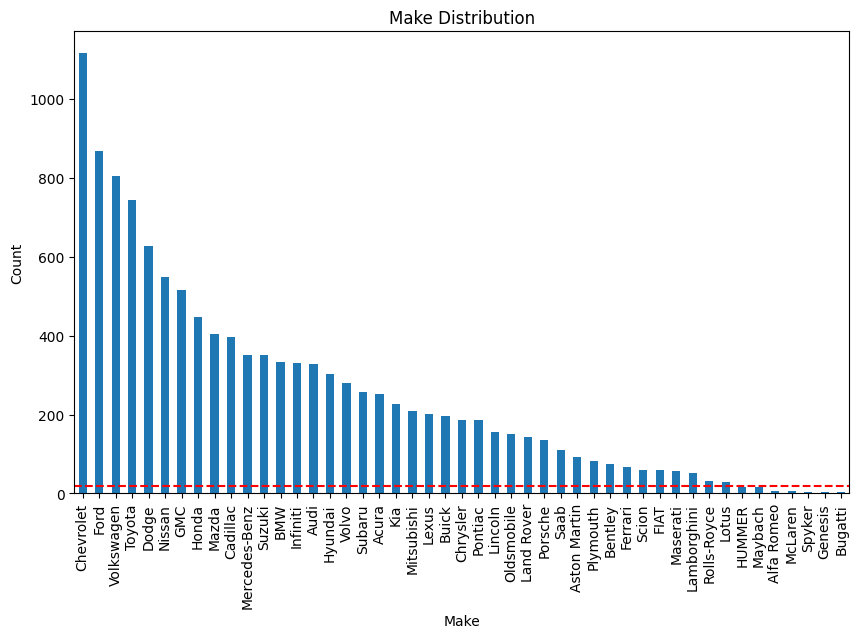

In [7]:
# Let's see the distribution of the y_feature. We want to have classes with at least 20 samples.
categories_count = df[y_feature].value_counts() # COMPLETE
plt.figure(figsize=(10, 6))
categories_count.plot(kind='bar', title=f"{y_feature} Distribution")
#show horizontal line for 20 
plt.axhline(y=20, color='r', linestyle='--')
plt.xlabel(y_feature)
plt.ylabel('Count')
plt.show()

We need to remove any entries from `Make` that have less than 20 samples. One solution is getting the indices of the Makes that have less than 20 samples and then dropping those rows from the DataFrame. You can use `isin()` method to filter the DataFrame.

In [8]:
# Remove classes with less than 20 samples
categories_to_remove = categories_count[categories_count < 20].index.tolist() # COMPLETE

print(categories_to_remove)

df = df[~df[y_feature].isin(categories_to_remove)] # COMPLETE



['HUMMER', 'Maybach', 'Alfa Romeo', 'McLaren', 'Spyker', 'Genesis', 'Bugatti']


Define `X` variables (input) and the `y` variable (target) in terms of the features.

In [9]:
X = df[x_features] # COMPLETE
y = df[y_feature] # COMPLETE

Let's now split the dataset into training and testing sets. Let's use a test_size of 0.3.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # COMPLETE


Let's train a simple DecisionTreeClassifier

In [11]:
# Initialize classifiers
# Decision Tree first
dt_classifier = DecisionTreeClassifier() # COMPLETE
# Fit the model
dt_classifier.fit(X_train, y_train) # COMPLETE


DecisionTreeClassifier()

Now let's predict and see the report for the decision tree classifier.

In [12]:
# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test) # COMPLETE
# Evaluate the Decision Tree model
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt)) # COMPLETE


Decision Tree Classifier:
               precision    recall  f1-score   support

        Acura       0.85      0.87      0.86        71
 Aston Martin       0.86      0.90      0.88        20
         Audi       0.90      0.82      0.86        97
          BMW       0.88      0.77      0.82        93
      Bentley       1.00      0.75      0.86        16
        Buick       0.67      0.66      0.67        56
     Cadillac       0.83      0.91      0.87       117
    Chevrolet       0.65      0.70      0.68       345
     Chrysler       0.73      0.62      0.67        53
        Dodge       0.83      0.83      0.83       199
         FIAT       0.89      0.94      0.92        18
      Ferrari       0.78      0.96      0.86        26
         Ford       0.88      0.94      0.91       256
          GMC       0.52      0.49      0.51       182
        Honda       0.87      0.91      0.89       140
      Hyundai       0.78      0.79      0.78        84
     Infiniti       0.88      0.82    

Plot the confusion matrix to visualize the performance of the model. You can use `confusion_matrix` from `sklearn.metrics` and `heatmap` from `seaborn` to visualize it.

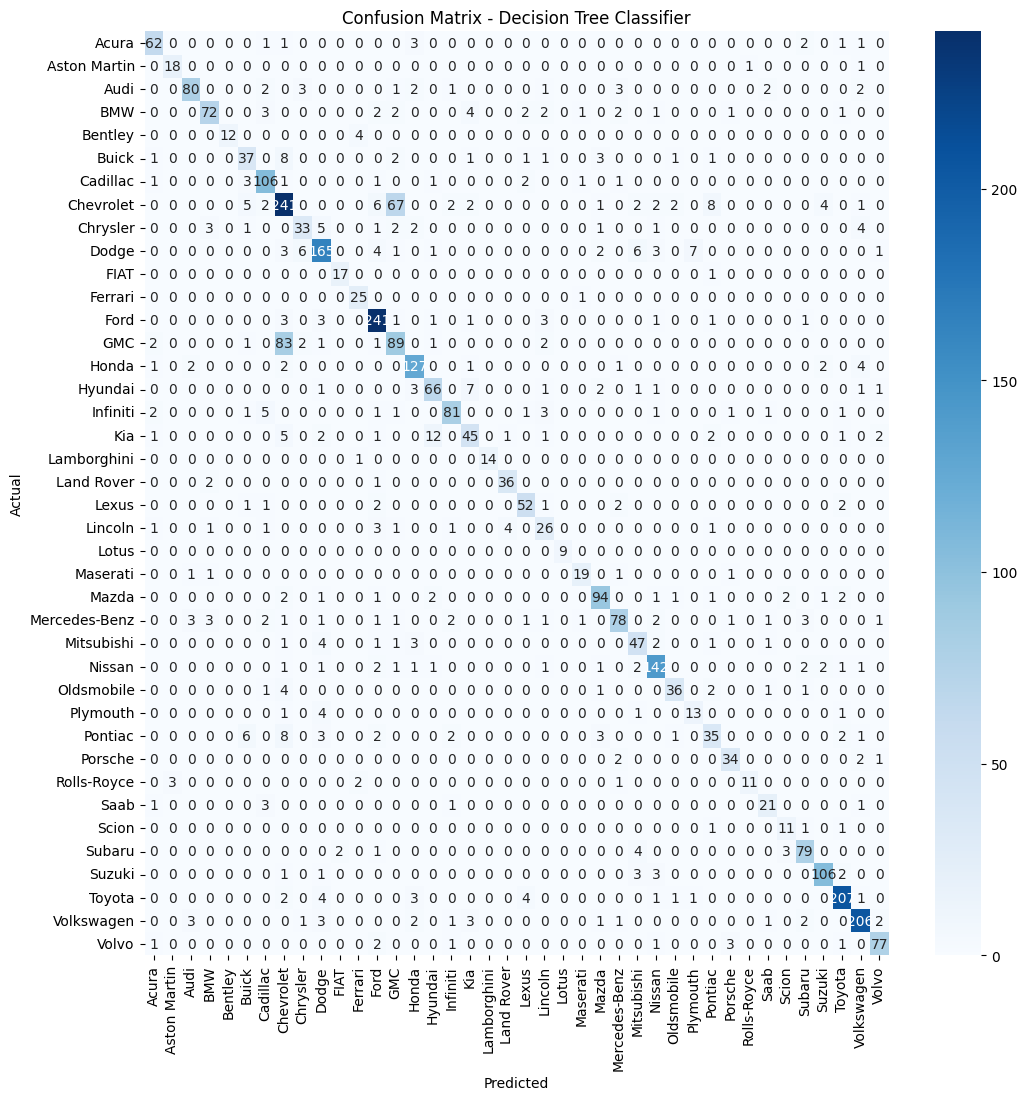

In [13]:

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt) # COMPLETE

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Do you see any interesting patterns in the confusion matrix? Discuss briefly any observations you have.

**OBSERVATIONS**

- The dataset is imbalance... some makers/brand have more observations than others. However it is expected as you will have less amount of cars for high-end brands, like Ferrari, Lamborghini.
- The correct classifications (also known as true positives) are along the diagonal. 
- There is one case that looked to be frequently misclassified in both directions, GMC <-> Chevrolet.
- Chevrolet -> Buick and Buick -> Chevrolet looks to be symetric (about the same number of misclassifications).
- Pontiac <-> Chevrolet looks to another case with similar number of misclassifications in both directions.
- KIA <-> Hyundai, but notice that misclassify KIA as Hyundai happend more than Hyundai as KIA.
- Bentley and Ferrari look to be the high end car makers that are less likely to end up misclassified.

---

Now let's explore the space of parameters for the Decision Tree Classifier. We will use `GridSearchCV` to perform a parameter search on the Decision Tree Classifier. We will search over `criterion`, `max_depth`, and `splitter`.

In [14]:
# Parameter space for Decision Tree Classifier
# Grid search will evaluate all combinations of these parameters
desicion_tree_params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50],
    'splitter': ["best", "random"]
}

# Perform grid search with cross-validation for Decision Tree Classifier
grid_search_decision_tree_classifier = GridSearchCV(
    DecisionTreeClassifier(),
    desicion_tree_params_grid,
    cv=10, # 10-fold cross-validation
    scoring='f1_macro', # Use F1 score for multiclass classification
    verbose=1
    )

grid_search_decision_tree_classifier.fit(X_train, y_train)

print("Decision Tree best grid score in cv: " + str(grid_search_decision_tree_classifier.best_score_))
print("Decision Tree grid test score: " + str(grid_search_decision_tree_classifier.score(X_test, y_test)))

# DEBUGGING
print("\nDecision Tree grid training score: " + str(grid_search_decision_tree_classifier.score(X_train, y_train)))


Fitting 10 folds for each of 56 candidates, totalling 560 fits
Decision Tree best grid score in cv: 0.8141013260728936
Decision Tree grid test score: 0.8115287311205455

Decision Tree grid training score: 0.9917447140847798


We can check the best parameters found by the grid search and the best score achieved.

In [15]:
decision_tree_best_params = grid_search_decision_tree_classifier.best_params_
print("Decision Tree best params: " + str(decision_tree_best_params))

Decision Tree best params: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}


The `grid_search_decision_tree_classifier` object works as a model. You can fit and transform data using it. Let's fit the model to the training data and then evaluate it on the test set.
So let's see how the model performs after the parameter search. We will use the `report` function to evaluate the model on the test set.

In [16]:
decision_tree_best_params = grid_search_decision_tree_classifier.best_params_
print("Decision Tree best params: " + str(decision_tree_best_params))

Decision Tree best params: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}


Now we can run `predict()` on our `grid_search_decision_tree_classifier`.

In [17]:
y_pred = grid_search_decision_tree_classifier.predict(X_test)

Let's look at the resulting report. Call `classification_report()` below.

In [18]:
grid_search_decision_tree_classification_report = classification_report(y_test, y_pred)
print("Decision Tree Classification report with test data")
print(grid_search_decision_tree_classification_report)

Decision Tree Classification report with test data
               precision    recall  f1-score   support

        Acura       0.89      0.82      0.85        71
 Aston Martin       0.95      0.95      0.95        20
         Audi       0.87      0.84      0.85        97
          BMW       0.88      0.81      0.84        93
      Bentley       1.00      1.00      1.00        16
        Buick       0.71      0.66      0.69        56
     Cadillac       0.90      0.91      0.90       117
    Chevrolet       0.65      0.67      0.66       345
     Chrysler       0.65      0.60      0.63        53
        Dodge       0.78      0.81      0.80       199
         FIAT       0.80      0.67      0.73        18
      Ferrari       0.93      0.96      0.94        26
         Ford       0.87      0.91      0.89       256
          GMC       0.53      0.52      0.53       182
        Honda       0.90      0.89      0.89       140
      Hyundai       0.79      0.88      0.83        84
     Infiniti

Now, let's see the feature importances of the Decision Tree Classifier. You can access the `feature_importances_` attribute of the trained model.

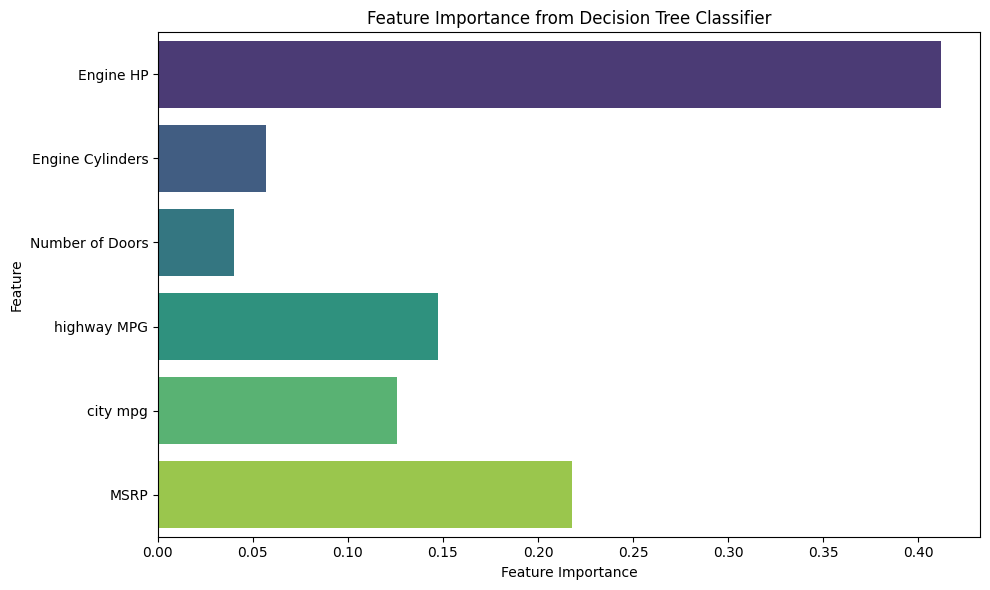

In [19]:
# Feature importance
feature_importances_dt = dt_classifier.feature_importances_ # COMPLETE
# Plot feature importances (you can use matplotlib or seaborn)


# YOUR CODE HERE

feature_importance_df = pd.DataFrame({'Feature': x_features, 'Importance': feature_importances_dt})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis', legend=False)
plt.title('Feature Importance from Decision Tree Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



We'll need to grab the features to use now, using the `SelectFromModel()` function. Then, let's run `fit()` on `select`.

In [20]:
select = SelectFromModel(DecisionTreeClassifier(), threshold='median')

# which features were selected?
print("Features before selection:")
print(X_train.columns.tolist())

select.fit(X_train, y_train) # Your Code Here
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

# which features were selected?
selected_features = X_train.columns[select.get_support()]
print("\nSelected features after selection:")
print(selected_features.tolist())

Features before selection:
['Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'MSRP']

Selected features after selection:
['Engine HP', 'highway MPG', 'MSRP']


Now let's apply those best params froem the grid search. Assign the respective fields from `decision_tree_best_params` for your classifier.

In [21]:
# Applying DecisionTreeClassifier using the best params from the grid search and with selected data
decision_tree_classifier = DecisionTreeClassifier(**decision_tree_best_params)

We need to run the `fit()` function using `X_train_selected` and `y_train` as parameters. Then, run `predict()` using `X_test_selected`.

In [22]:
decision_tree_classifier.fit(X_train_selected, y_train) # COMPLETE
y_pred_selected = decision_tree_classifier.predict(X_test_selected) # COMPLETE

In [23]:
# Get training accuracy DEBUGGING
train_accuracy = decision_tree_classifier.score(X_train_selected, y_train)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.9862764148651931


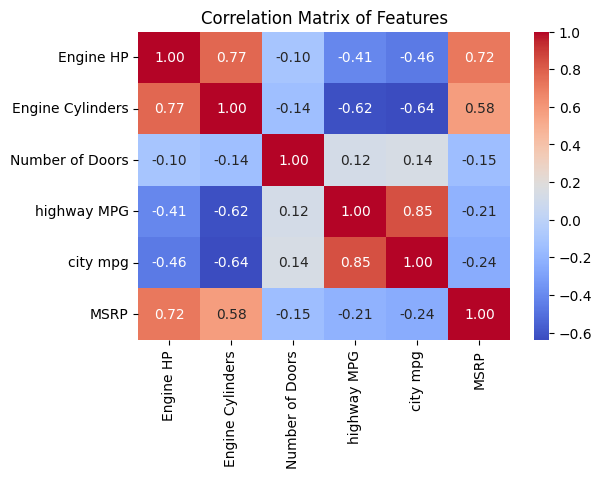

In [24]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

Lastly, rerun the `classification_report()` and print out what your results are.

In [25]:
# Lastly, rerun the `classification_report()` and print out what your results are.
decision_tree_classification_report_selected = classification_report(y_test, y_pred_selected) # COMPLETE
print("Decision Tree Classification report with selected features")
print(decision_tree_classification_report_selected)


Decision Tree Classification report with selected features
               precision    recall  f1-score   support

        Acura       0.84      0.82      0.83        71
 Aston Martin       0.90      0.95      0.93        20
         Audi       0.82      0.68      0.75        97
          BMW       0.79      0.81      0.80        93
      Bentley       0.48      0.69      0.56        16
        Buick       0.53      0.71      0.61        56
     Cadillac       0.90      0.80      0.85       117
    Chevrolet       0.65      0.69      0.67       345
     Chrysler       0.49      0.62      0.55        53
        Dodge       0.78      0.73      0.75       199
         FIAT       0.82      0.78      0.80        18
      Ferrari       0.80      0.92      0.86        26
         Ford       0.84      0.86      0.85       256
          GMC       0.52      0.45      0.48       182
        Honda       0.81      0.81      0.81       140
      Hyundai       0.67      0.81      0.74        84
     

**Do you see any improvements?**

Not any major improvement. The accuracy of the model decrease from 0.81 → 0.78 is small, about ~3%.

So it could suggest:

- The features dropped (`Engine Cylinders`, `Number of Doors`, `city mpg`) do not look to be critically important.

- A smaller feature set (variables that explain) implies a simpler, faster, more general, and easier model to interpret.

- Notice that there features that have high correlation, e.g. `city mpg` and `highway MPG` so by dropping `highway MPG` so we end up with less multicollinearity, hence improving model robustness, and trading-off a small additional information that the extra feature may bring (high correlation between features mean that we have redundant information in a way). A similar case is observed between `Engine HP` and `Engine Cylinders`.

Looking at the training accuracy, it dropped a bit (0.99 to 0.98) so a bit of over-fitting went away - but nothing major, I will think. 

---

Finally, let's plot the ROC (Receiver Operating Characteristic) curve to evaluate the performance of our model. Note that we will need to use the `predict_proba()` method to get the probabilities for each class. Feel free to choose one of the classes, for example, `Toyota`. Note that Decision Tree Classifier is not the best for ROC curves as they are not probabilistic models, but we can still plot it for the sake of this exercise. The ROC curves for the other classifiers will be more meaningful.

Plot the ROC with a line for the random classifier (diagonal line) and the ROC curve for the Decision Tree Classifier. Calculate the area under the curve (AUC). You can use `roc_curve` and `auc` from `sklearn.metrics`.

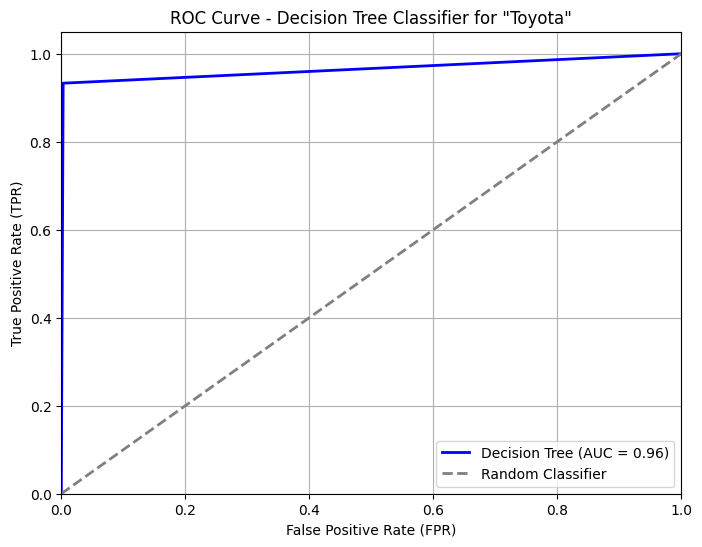

In [26]:
# ROC
from sklearn.metrics import roc_curve, auc
y_score = grid_search_decision_tree_classifier.predict_proba(X_test)
chosenClass = "Toyota"
chosenClassIndex = grid_search_decision_tree_classifier.classes_.tolist().index(chosenClass)
fpr, tpr, _ = roc_curve(y_test == chosenClass, y_score[:, chosenClassIndex])
roc_auc = auc(fpr, tpr)


# Plot ROC curves: tpr vs fpr (x-axis is fpr, y-axis is tpr)
# Don't forget to draw the random guess line (y=x) use dash line 

# YOUR CODE HERE
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve - Decision Tree Classifier for "{chosenClass}"')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Now let's repeat the steps 3-6 for Logistic Regression, KNeighborsClassifier, RandomForestClassifier, and SVM (SVC).

For Logistic Regression and SVM we recommend using standardized X features. You can use `StandardScaler` from `sklearn.preprocessing` to standardize the features.

For instance, let's prepare the data for Logistic Regression and SVC:

In [27]:
# Logistic regression works best if the data is scaled, so we will scale the data using StandardScaler.
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Now similarly perform the above operations for Logistic Regression

In [28]:
# Your Code Here

lr= LogisticRegression(C=1000.0, random_state=42,max_iter=1000) #Your Code Here
# Using settings from HW 7

lr.fit(X_train_scaled, y_train.to_numpy())  # .ravel() will be deprecated
y_pred= lr.predict(X_test_scaled)

print(f'Accuracy Logistic Regression: {accuracy_score(y_test, y_pred)}')

Accuracy Logistic Regression: 0.20770756588268632


In [29]:
decision_tree_classification_report = classification_report(y_test, y_pred, zero_division=np.nan)
print("Logistic Regression Classification report")
print(decision_tree_classification_report)

Logistic Regression Classification report
               precision    recall  f1-score   support

        Acura        nan      0.00      0.00        71
 Aston Martin       0.44      0.75      0.56        20
         Audi       0.15      0.11      0.13        97
          BMW       0.23      0.20      0.21        93
      Bentley       0.47      0.56      0.51        16
        Buick       0.50      0.05      0.10        56
     Cadillac       0.21      0.25      0.23       117
    Chevrolet       0.11      0.24      0.15       345
     Chrysler       0.17      0.08      0.11        53
        Dodge       0.15      0.17      0.16       199
         FIAT       0.00      0.00      0.00        18
      Ferrari       0.77      0.77      0.77        26
         Ford       0.16      0.19      0.18       256
          GMC       0.16      0.10      0.12       182
        Honda       0.45      0.18      0.26       140
      Hyundai        nan      0.00      0.00        84
     Infiniti       0.

Now similarly perform the above operations for KNeighborsClassifier. 

In [30]:
# Your Code Here

from sklearn.neighbors import KNeighborsClassifier

# Using one neighbor 
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean') # Your Code here

#Your Code to fit the model here
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled) # Your Prediction Code Here

# Your Accuracy Output Code Here
print(f'Accuracy KNN: {accuracy_score(y_test, y_pred_knn)}')

Accuracy KNN: 0.8231793709266081


In [31]:
knn_decision_tree_classification_report = classification_report(y_test, y_pred_knn, zero_division=np.nan)
print("KNN Classification report")
print(knn_decision_tree_classification_report)

KNN Classification report
               precision    recall  f1-score   support

        Acura       0.84      0.86      0.85        71
 Aston Martin       1.00      1.00      1.00        20
         Audi       0.83      0.88      0.85        97
          BMW       0.88      0.85      0.86        93
      Bentley       0.68      0.94      0.79        16
        Buick       0.76      0.70      0.73        56
     Cadillac       0.91      0.92      0.92       117
    Chevrolet       0.67      0.67      0.67       345
     Chrysler       0.69      0.64      0.67        53
        Dodge       0.82      0.82      0.82       199
         FIAT       0.89      0.94      0.92        18
      Ferrari       1.00      1.00      1.00        26
         Ford       0.85      0.93      0.89       256
          GMC       0.54      0.54      0.54       182
        Honda       0.91      0.92      0.92       140
      Hyundai       0.80      0.80      0.80        84
     Infiniti       0.91      0.82    

Now similarly perform the above operations for Random Forest. 

In [32]:
# Your Code Here

# Using some default for random forest

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred_rf = model.predict(X_test_scaled)
print(f'Accuracy Random Forest: {accuracy_score(y_test, y_pred_rf):.4f}')


Accuracy Random Forest: 0.8461


In [33]:
RF_decision_tree_classification_report = classification_report(y_test, y_pred_rf, zero_division=np.nan)
print("Random Forest Classification report")
print(RF_decision_tree_classification_report)

Random Forest Classification report
               precision    recall  f1-score   support

        Acura       0.90      0.89      0.89        71
 Aston Martin       0.79      0.95      0.86        20
         Audi       0.90      0.89      0.89        97
          BMW       0.91      0.84      0.87        93
      Bentley       0.89      1.00      0.94        16
        Buick       0.81      0.75      0.78        56
     Cadillac       0.90      0.94      0.92       117
    Chevrolet       0.67      0.70      0.69       345
     Chrysler       0.77      0.70      0.73        53
        Dodge       0.86      0.85      0.85       199
         FIAT       0.89      0.94      0.92        18
      Ferrari       0.96      1.00      0.98        26
         Ford       0.87      0.92      0.90       256
          GMC       0.57      0.56      0.57       182
        Honda       0.95      0.91      0.93       140
      Hyundai       0.84      0.90      0.87        84
     Infiniti       0.92    

Now similarly perform the above operations for SVM (SVC).

In [34]:
# Your Code Here
from sklearn.svm import SVC

# Using RBF as it looks to work better than linear kernel

svm = SVC(kernel='rbf') # Your Code Here
    # kernel='linear', C=1.0, random_state=0, cache_size=7000

svm.fit(X_train_scaled, y_train.to_numpy())     # ravel() will be deprecated
y_pred_svm = svm.predict(X_test_scaled) # Your Prediction Code Here

print(f'Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: {accuracy_score(y_test, y_pred_svm)}')

Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.30036837631056956


In [35]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [36]:
svm_decision_tree_classification_report = classification_report(y_test, y_pred_svm, zero_division=np.nan)
print("SVM Classification report")
print(svm_decision_tree_classification_report)

SVM Classification report
               precision    recall  f1-score   support

        Acura       0.26      0.31      0.28        71
 Aston Martin       0.57      1.00      0.73        20
         Audi       0.12      0.07      0.09        97
          BMW       0.29      0.29      0.29        93
      Bentley       0.64      1.00      0.78        16
        Buick        nan      0.00      0.00        56
     Cadillac       0.38      0.45      0.41       117
    Chevrolet       0.19      0.54      0.29       345
     Chrysler       0.00      0.00      0.00        53
        Dodge       0.33      0.25      0.28       199
         FIAT       0.00      0.00      0.00        18
      Ferrari       0.96      0.92      0.94        26
         Ford       0.24      0.26      0.25       256
          GMC        nan      0.00      0.00       182
        Honda       0.37      0.20      0.26       140
      Hyundai       0.90      0.11      0.19        84
     Infiniti       0.57      0.13    

Based on all the classification reports, which classifier performed best? Discuss the performance of each classifier and the impact of feature selection and parameter tuning on the results.

**YOUR DISCUSSION HERE**

#### **Summary Table** ####

|Accuracy| Result|
|---|:---:|
|Logistic Regression|0.20770756588268632
|KNN| 0.8231793709266081
|Random Forest| 0.8461
|Support Vector Machine with<br/> a Radial Basis Function (RBF) kernel| 0.30036837631056956

**Random Forest** is a powerful ensemble method that typically handles noise, irrelevant features, and non-linear data very well. It benefits from aggregating many decision trees, which reduces overfitting and improves generalization, likely explaining its better performance in comparison to the other models.

<br/>

**KNN** is a simple yet effective method when the data has clear class boundaries. Its good performance suggests that the features selected offer good clustering/separation between classes. Also, the Scaling was a factor that benefited KNN model.

Interesting to observe that there are some makers where KNN is outperforming Random Forest (Aston Martin is the more evident), like: 

|Make|Random Forest Classification|||KNN Classification|||
|---|:---:|:---:|:---:|:---:|:---:|:---:|
|  |precision (RF)|	recall (RF)|	f1-score (RF)|	precision (KNN)|	recall (KNN)|	f1-score (KNN)|
|Aston Martin|0.79|	0.95|	0.86|	1|	1|	1|
|Ferrari   | 0.96|	1|	0.98|	1|	1|	1|
|Land Rover| 0.92|	0.9|	0.91|	0.95|	0.92|	0.94|
|Lexus     | 0.76|0.85|	0.81|	0.81|	0.84|	0.82|
|Lotus     | 0.9|1|	0.95|	1|	1|	1|
|Maserati  | 1  |0.91	|0.95	|0.96	|0.96	|0.96|
|Pontiac   |0.68|	0.57|	0.62|	0.7|	0.62|	0.66|


For the following makers, the have pretty much the same result.

|Make|Random Forest Classification|||KNN Classification|||
|---|:---:|:---:|:---:|:---:|:---:|:---:|
|  |precision (RF)|	recall (RF)|	f1-score (RF)|	precision (KNN)|	recall (KNN)|	f1-score (KNN)|
|Cadillac|	0.9|	0.94|	0.92|	0.91|	0.92|	0.92|
|FIAT	|0.89	|0.94	|0.92	|0.89	|0.94	|0.92|
|Lamborghini|	0.94	|1	|0.97	|0.94	|1	|0.97|
|Rolls-Royce|	1	|0.82	|0.9	|1	|0.82	|0.9|

<br/>

**SVM with RBF Kernel** usually does well on non-linear problems, but its poor performance suggests that the parameters (like C, gamma) were not well tuned.

If we play with the `C` and `gamma` parameters then we can find a better model:

|Tuned Support Vector Machine|Accuracy |
|---|---|
|Using Radial Basis Function (RBF) kernel<br/>using `C` = 10, `gamma` = 1|0.6225559648625673|

<br/>

**Logistic Regression** works best when the decision boundary between classes is linear. Its low accuracy suggests that the data has complex, non-linear relationships that Logistic Regression couldn't capture. The Scaling helped the model but not enough. In comparison, the other models looked to be handling better the non-linearity.

Logistic Regression shows recall zero for 8 Makers (Acura,FIAT,Hyundai,Infiniti,Kia,Lincoln,Mitsubishi,Scion), it fails to identify any of the positive instances for any of these makers.

<br/>

**Final Remarks**

Considering how simple KNN works and it can be explained then it it is remarkable that it accomplished in comparison to the best one (Random Forest).

In [37]:
# Try different parameters for SVM 

for parameter_C in [1, 10]:
    for parameter_gamma in [1, 0.1]:

        svm = SVC(kernel='rbf', C=parameter_C, gamma=parameter_gamma) # Your Code Here

        svm.fit(X_train_scaled, y_train.to_numpy())     # ravel() will be deprecated
        y_pred_svm = svm.predict(X_test_scaled) # Your Prediction Code Here

        print(f'\nParameter C: {parameter_C} | Parameter Gamma: {parameter_gamma}')
        print(f'Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: {accuracy_score(y_test, y_pred_svm)}')



Parameter C: 1 | Parameter Gamma: 1
Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.47747237177670726

Parameter C: 1 | Parameter Gamma: 0.1
Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.2674978747520544

Parameter C: 10 | Parameter Gamma: 1
Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.6225559648625673

Parameter C: 10 | Parameter Gamma: 0.1
Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.36695947860583733


In [38]:
# Using better settings for SVM

parameter_C = 10
parameter_gamma = 1

svm = SVC(kernel='rbf', C=parameter_C, gamma=parameter_gamma) # Your Code Here

svm.fit(X_train_scaled, y_train.to_numpy())     # ravel() will be deprecated
y_pred_svm = svm.predict(X_test_scaled) # Your Prediction Code Here

print(f'\nParameter C: {parameter_C} | Parameter Gamma: {parameter_gamma}')
print(f'Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: {accuracy_score(y_test, y_pred_svm)}')



Parameter C: 10 | Parameter Gamma: 1
Accuracy Support Vector Machine with a Radial Basis Function (RBF) kernel: 0.6225559648625673


In [39]:
tunned_svm_decision_tree_classification_report = classification_report(y_test, y_pred_svm, zero_division=np.nan)
print("SVM Classification report (gamma=1, C=10)")
print(tunned_svm_decision_tree_classification_report)

SVM Classification report (gamma=1, C=10)
               precision    recall  f1-score   support

        Acura       0.50      0.52      0.51        71
 Aston Martin       1.00      1.00      1.00        20
         Audi       0.59      0.55      0.57        97
          BMW       0.67      0.76      0.71        93
      Bentley       0.64      0.88      0.74        16
        Buick       0.51      0.32      0.40        56
     Cadillac       0.68      0.65      0.67       117
    Chevrolet       0.46      0.72      0.56       345
     Chrysler       0.57      0.60      0.59        53
        Dodge       0.68      0.59      0.63       199
         FIAT       0.64      0.39      0.48        18
      Ferrari       1.00      1.00      1.00        26
         Ford       0.63      0.70      0.66       256
          GMC       0.59      0.30      0.40       182
        Honda       0.72      0.64      0.68       140
      Hyundai       0.61      0.43      0.50        84
     Infiniti       0.